In [1]:
import sys
import numpy
import matplotlib
import pandas
import keras

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
Numpy: 1.16.2
Matplotlib: 3.0.3
Pandas: 0.24.2
Keras: 2.2.4


In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers import Input, Dropout
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
import keras.backend as K
from keras.applications.resnet50 import preprocess_input, decode_predictions


model = ResNet50(weights = 'imagenet',
                include_top = True)

model.summary()


img_size = 224

input_tensor = Input(shape=(img_size, img_size, 3))

base_model = ResNet50(
    weights='imagenet',
    include_top = False,
    input_tensor = input_tensor)
    
#     input_tensor = input_tensor)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________

C:\Users\Tommy Kwan\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
for layer in base_model.layers:
    layer.trainable = True
    
base_model.layers[0].trainable = False
base_model.layers[1].trainable = False

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# x = Dense(
#     1024,
#     activation = 'relu')(x)

# x = Dropout(0.5)(x)

# x = Dense(
#     512,
#     activation = 'relu')(x)

output = Dense(
    5,
    activation='softmax')(x)

model = Model(
    inputs=base_model.input,
    outputs=output)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.0)
#     width_shift_range=0.2,
#     height_shift_range=0.2)

valid_datagen = ImageDataGenerator(
    rescale=1./255)



In [34]:
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        './valid',
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='categorical')

Found 4529 images belonging to 5 classes.
Found 1127 images belonging to 5 classes.


In [35]:
x_batch, y_batch = next(train_generator)

In [36]:
print(x_batch.max())
print(x_batch.min())

1.0
0.0


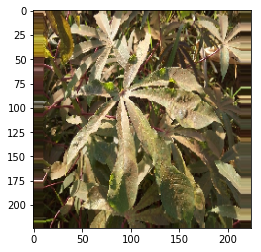

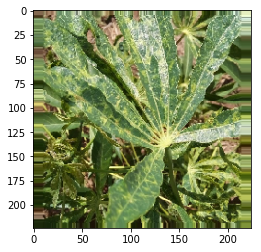

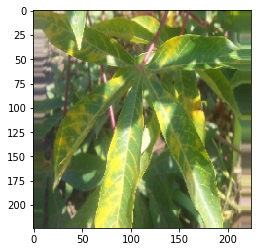

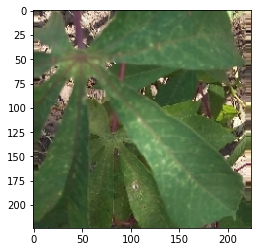

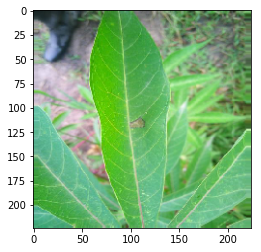

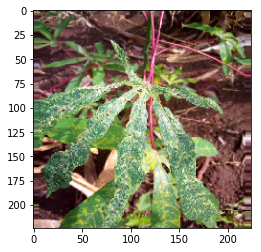

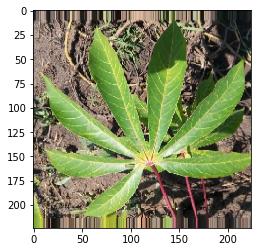

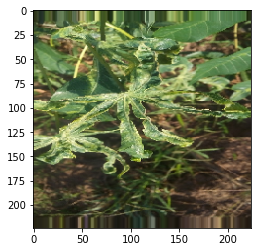

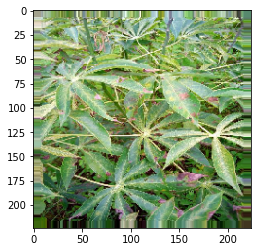

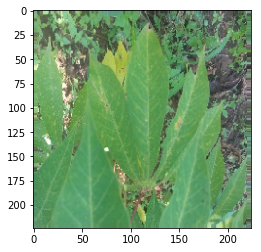

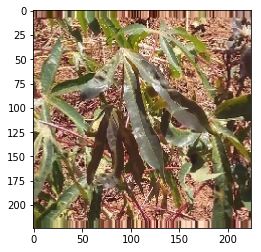

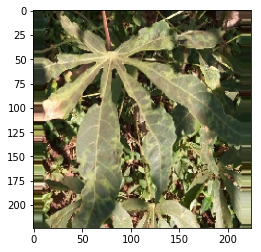

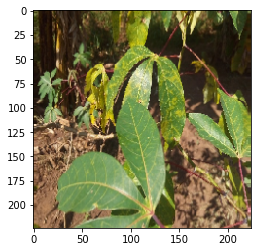

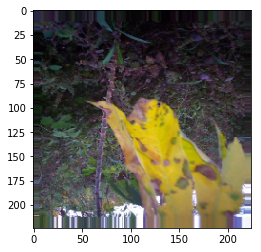

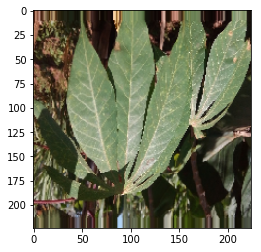

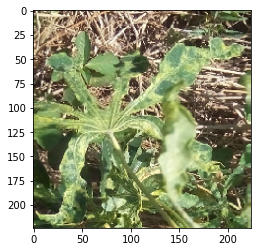

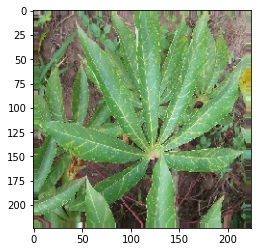

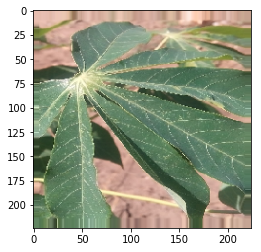

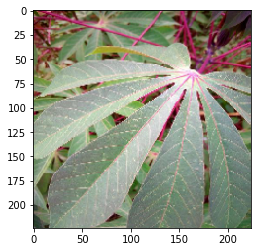

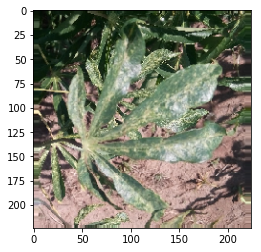

In [37]:
import matplotlib.pyplot as plt

for i in range (0,20):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

In [12]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr = 1e-5),
              metrics = ['accuracy'])

# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     verbose=1,
#     restore_best_weights=False)

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

# checkpoint = ModelCheckpoint(
#     filepath,
#     monitor='val_acc',
#     verbose=1,
#     save_best_only=True,
#     mode='max',
#     period = 5)


In [13]:
history = model.fit_generator(
    generator = train_generator,
    validation_steps = valid_generator.n // valid_generator.batch_size + 1,
    validation_data = valid_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size + 1,
    epochs = 5)
#                    callbacks = [checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
227/227 [==============================] - 4767s 21s/step - loss: 0.3439 - acc: 0.8552 - val_loss: 0.2530 - val_acc: 0.8997
Epoch 2/5
227/227 [==============================] - 4614s 20s/step - loss: 0.2427 - acc: 0.9021 - val_loss: 0.2245 - val_acc: 0.9107
Epoch 3/5
227/227 [==============================] - 4582s 20s/step - loss: 0.2043 - acc: 0.9194 - val_loss: 0.2059 - val_acc: 0.9205
Epoch 4/5
227/227 [==============================] - 4578s 20s/step - loss: 0.1765 - acc: 0.9311 - val_loss: 0.2089 - val_acc: 0.9191
Epoch 5/5
227/227 [==============================] - 4547s 20s/step - loss: 0.1567 - acc: 0.9401 - val_loss: 0.2015 - val_acc: 0.9249


In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(
                directory="./test",
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode='categorical',
                target_size=(img_size,img_size))

STEP_SIZE_TEST=test_generator.n
test_generator.reset()

Found 3774 images belonging to 1 classes.


In [16]:
pred = model.predict_generator(
    test_generator,
    steps = STEP_SIZE_TEST,
    verbose=1)

3774/3774 [==============================] - 669s 177ms/step


In [17]:
import numpy as np
import pandas as pd 

predicted_class_indices=np.argmax(
    pred,
    axis=1)

In [18]:
len(predicted_class_indices)

3774

In [19]:
predicted_class_indices[:10]

array([1, 1, 3, 2, 1, 3, 3, 3, 3, 2], dtype=int64)

In [20]:
len(predicted_class_indices)

3774

In [21]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames = test_generator.filenames
results = pd.DataFrame({"Category":predictions,
                      "id":filenames})

In [22]:
results.head()

,Category,id
0,cbsd,0\test-img-0.jpg
1,cbsd,0\test-img-1.jpg
2,cmd,0\test-img-10.jpg
3,cgm,0\test-img-100.jpg
4,cbsd,0\test-img-1000.jpg


In [23]:
results.Category.value_counts()

cmd        1855
cbsd        849
cgm         473
healthy     333
cbb         264
Name: Category, dtype: int64

In [24]:
results.head()

,Category,id
0,cbsd,0\test-img-0.jpg
1,cbsd,0\test-img-1.jpg
2,cmd,0\test-img-10.jpg
3,cgm,0\test-img-100.jpg
4,cbsd,0\test-img-1000.jpg


In [25]:
results.to_csv("submission.csv",index=False)

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


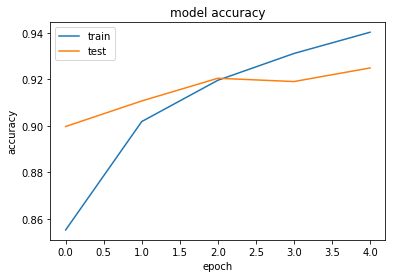

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

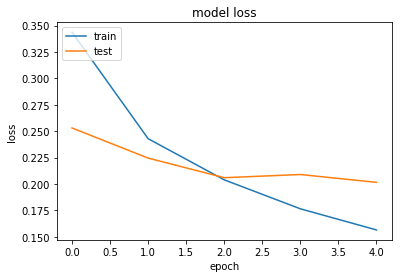

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()